In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

In [81]:
query_df = pd.read_csv('Test_Data/query_dataset.csv')
reference_df = pd.read_csv('Test_Data/reference_dataset.csv')

In [82]:
wavenumbers = query_df.columns[:-1]
query_intensities = query_df[wavenumbers].values
reference_intensities = reference_df[wavenumbers].values

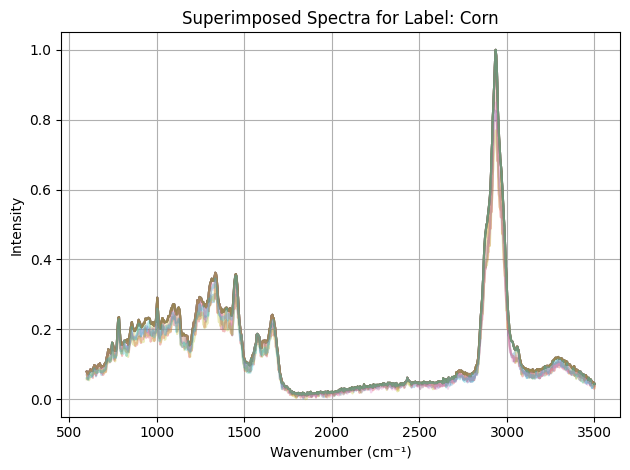

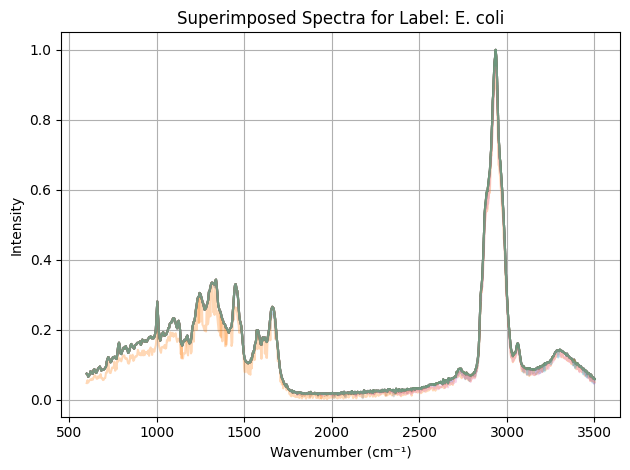

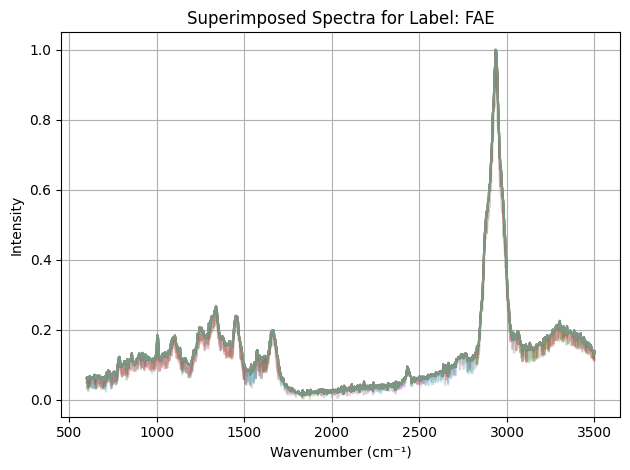

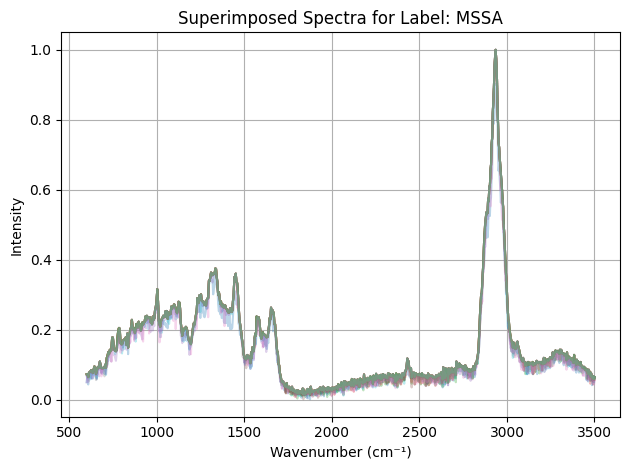

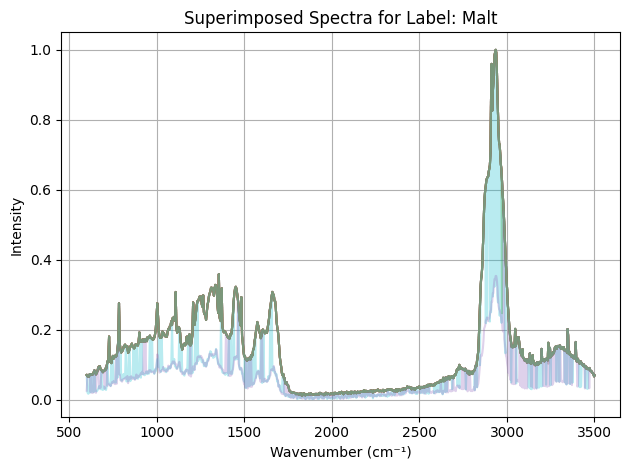

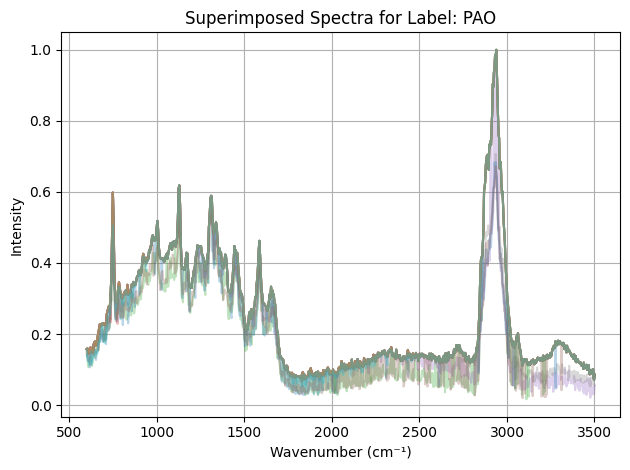

In [83]:

# Extract labels from the reference dataset
reference_labels = reference_df.iloc[:, -1]
unique_labels = reference_labels.unique()

# Plot each label with all spectra superimposed
for label in unique_labels:
    plt.figure()
    spectra = reference_df[reference_df.iloc[:, -1] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [84]:
def baseline_als(y,lam = 1e5,p = 0.01,niter = 10):
    L = len(y)
    D = np.diff(np.eye(L),2)
    D = lam * (D @ D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w)
        Z = W + D
        baseline = np.linalg.solve(Z,w * y)

        w = p* (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        spec_corr = spec - bkg
        norm = np.linalg.norm(spec_corr)
        out[i] = spec_corr / norm if norm != 0 else spec_corr
    return out

In [85]:
query_corrected = preprocess(query_intensities)
reference_corrected = preprocess(reference_intensities)

In [86]:
query_proc_df = pd.DataFrame(query_corrected, columns=wavenumbers)
query_proc_df['Species'] = query_df['Species']

reference_proc_df = pd.DataFrame(reference_corrected, columns=wavenumbers)
reference_proc_df['Species'] = reference_df['Species']

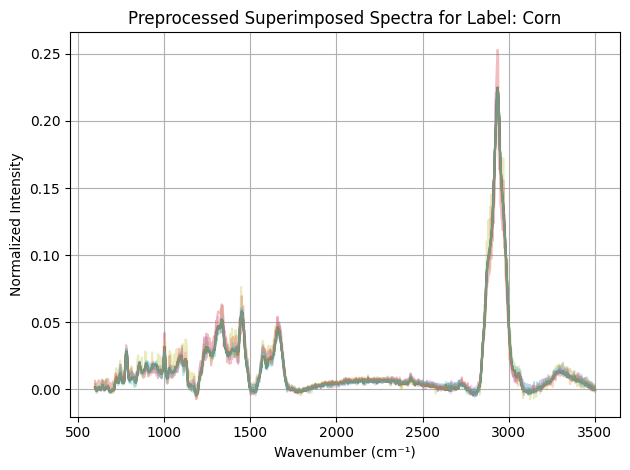

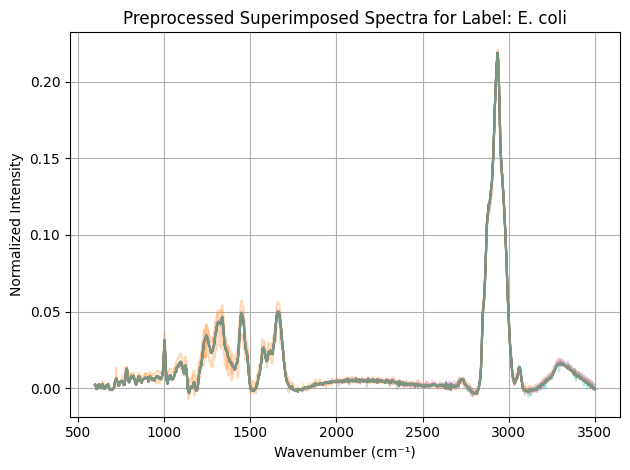

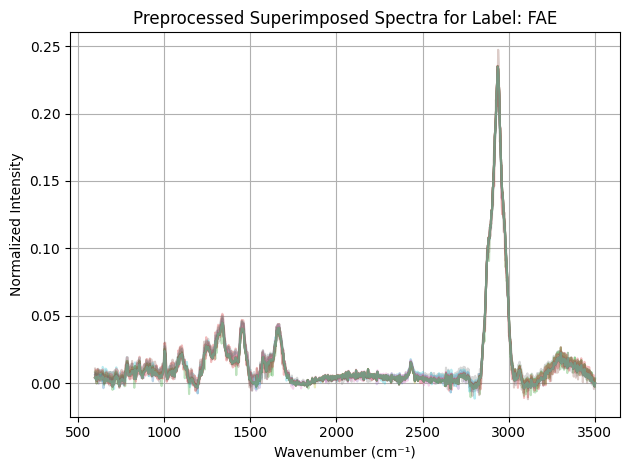

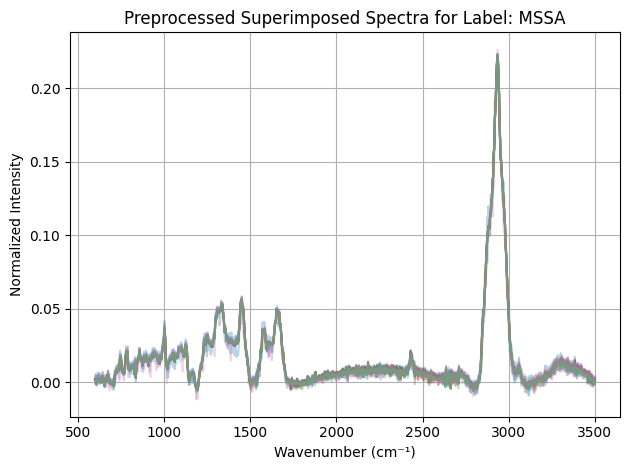

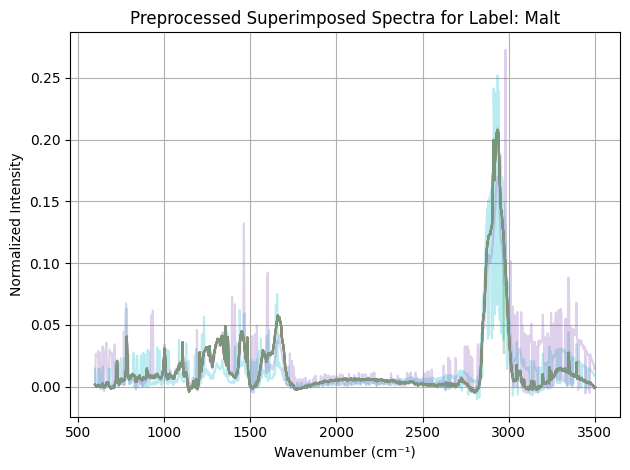

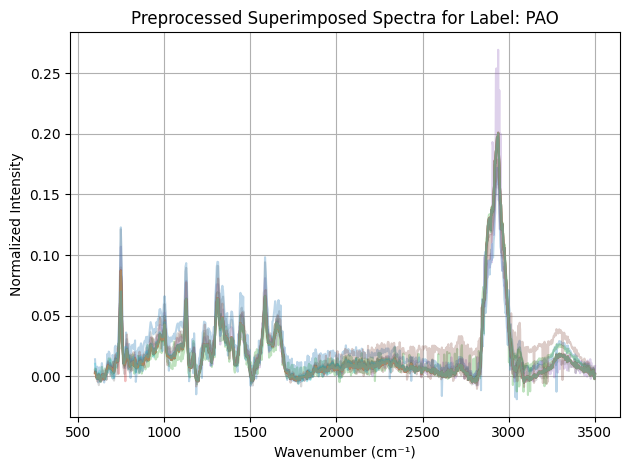

In [87]:
unique_labels = reference_proc_df['Species'].unique()

for label in unique_labels:
    plt.figure()
    spectra = reference_proc_df[reference_proc_df['Species'] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Preprocessed Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Normalized Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [88]:
raw_query = pd.read_csv('Test_Data/query_dataset.csv')
raw_ref = pd.read_csv('Test_Data/reference_dataset.csv')
wavs = raw_query.columns[:-1]

def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y); D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        baseline = np.linalg.solve(Z, w*y)
        w = p * (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(intensities):
    out = np.zeros_like(intensities)
    for i, spec in enumerate(intensities):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr/nrm if nrm!=0 else corr
    return out


Q = preprocess(raw_query[wavs].values)
R = preprocess(raw_ref[wavs].values)
dfQ = pd.DataFrame(Q, columns=wavs); dfQ['Species'] = raw_query['Species']
dfR = pd.DataFrame(R, columns=wavs); dfR['Species'] = raw_ref['Species']

In [89]:
K_smooth, N_peak, w_max = 5,10,36
def smooth_spectrum(spec): return np.convolve(spec,np.ones(K_smooth)/K_smooth,mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s)
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return cp_idxs

def extract_vec(spec, cp_idxs):
    hw = w_max//2
    vec = [spec[max(0,i-hw):min(len(spec),i+hw+1)].max() for i in cp_idxs]
    return minmax_scale(vec)

In [90]:
CPs, compressed_ref = {}, {}
for chem, grp in dfR.groupby('Species'):
    cp = CaPE(grp[wavs].values)
    CPs[chem] = cp
    compressed_ref[chem] = np.array([extract_vec(s, cp) for s in grp[wavs].values])

CPs = {}
compressed_ref = {}
for chem, grp in dfR.groupby('Species'):
    refs = grp[wavs].values
    cp_idxs = CaPE_peak_intensity(refs)
    CPs[chem] = cp_idxs
    compressed_ref[chem] = np.array([extract_vec(s, cp_idxs) for s in refs])

In [91]:
def CaPSim(qv, rvs): return (rvs @ qv).mean()
def identify(spec):
    scores = {}
    for chem, cp in CPs.items():
        qv = extract_vec(spec, cp)
        scores[chem] = CaPSim(qv, compressed_ref[chem])
    best = max(scores, key=scores.get)
    return best, scores


In [92]:
top1_correct = 0
top2_correct = 0
total = len(dfQ)

for _, row in dfQ.iterrows():
    true_label = row['Species']
    
    # 1) Get the raw similarity scores dict, {chem: score}
    scores = identify(row[wavs].values)[1]
    
    # 2) Rank chemicals by score descending
    ranked_chems = sorted(scores, key=scores.get, reverse=True)
    
    # 3) Check top-1
    if true_label == ranked_chems[0]:
        top1_correct += 1
    
    # 4) Check top-2
    if true_label in ranked_chems[:2]:
        top2_correct += 1

# Compute accuracies
top1_accuracy = top1_correct / total
top2_accuracy = top2_correct / total

print(f"Top-1 accuracy over {total} queries: {top1_accuracy:.2%}")
print(f"Top-2 accuracy over {total} queries: {top2_accuracy:.2%}")


Top-1 accuracy over 60 queries: 33.33%
Top-2 accuracy over 60 queries: 33.33%


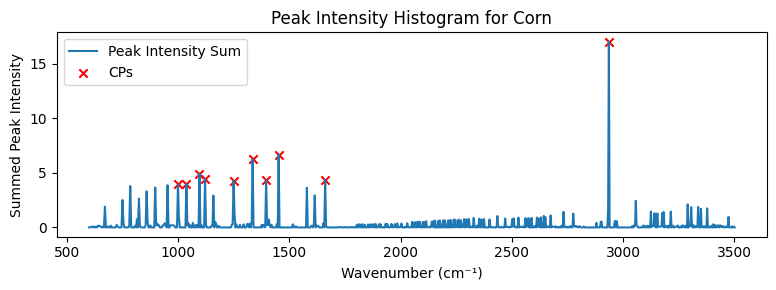

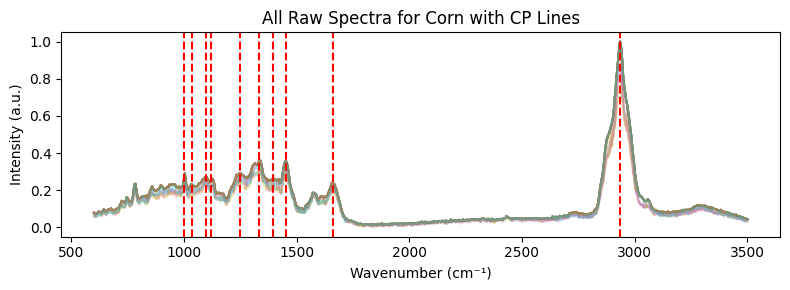

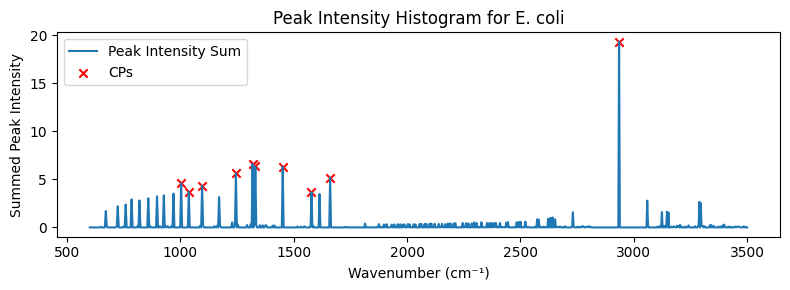

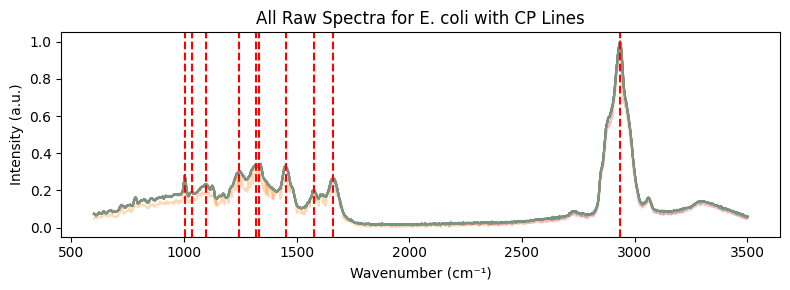

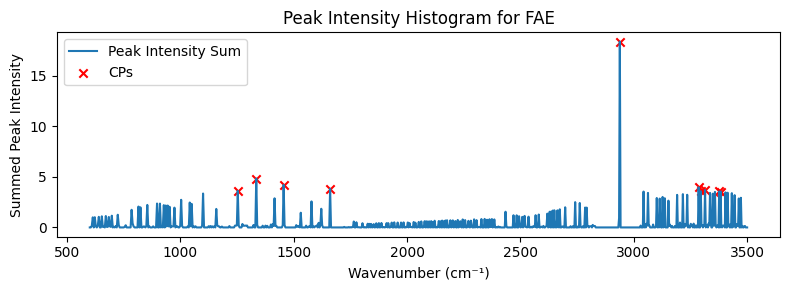

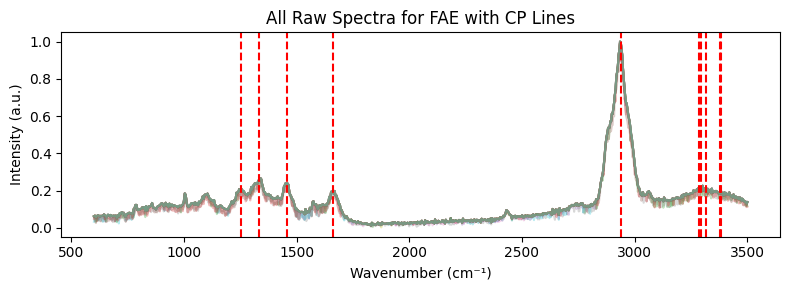

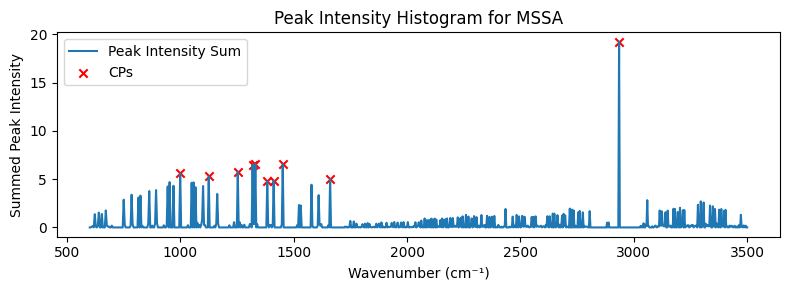

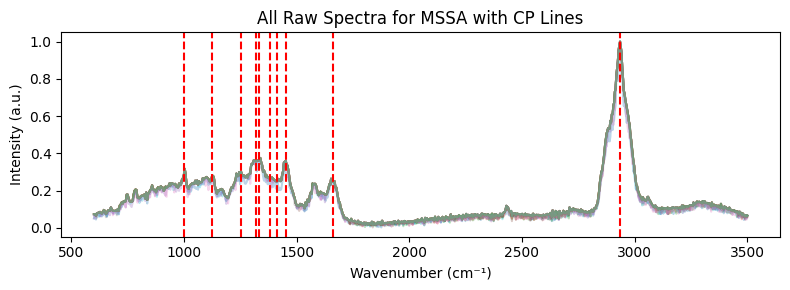

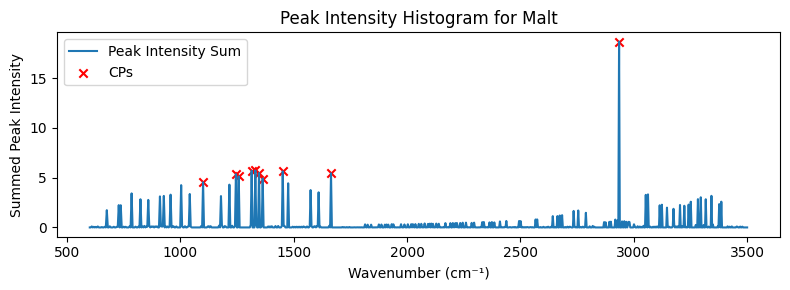

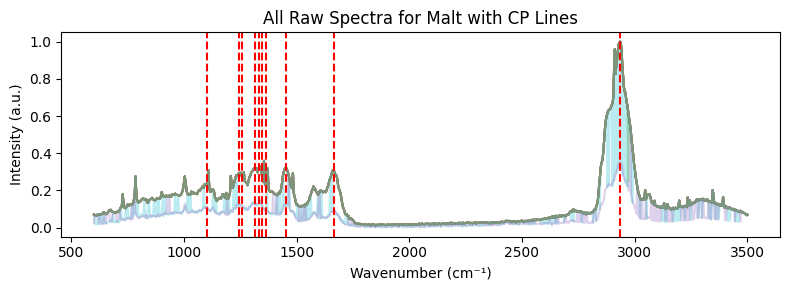

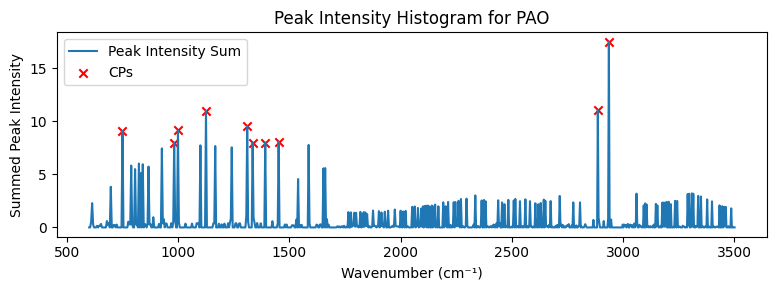

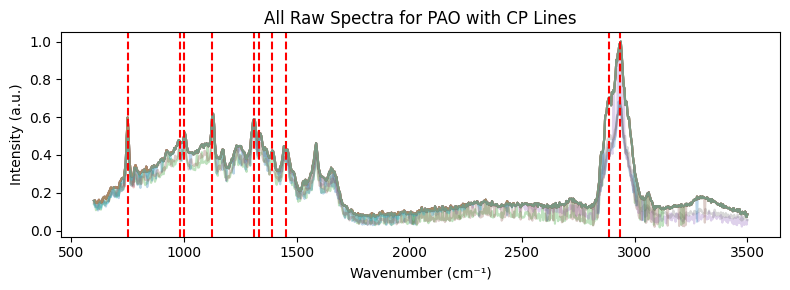

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load raw reference data
raw_ref = pd.read_csv('Test_Data/reference_dataset.csv')
wavs_str = raw_ref.columns[:-1]
wavs = wavs_str.astype(float)

# CaPE parameters
K_smooth, N_peak = 5, 10

# Smoothing function
def smooth_spectrum(spec, k=K_smooth):
    return np.convolve(spec, np.ones(k)/k, mode='same')

# New CaPE using peak intensities
def CaPE_peak_intensity(refs):
    """
    refs: array of shape (n_spectra, n_wavenumbers)
    returns:
      peak_intensity: total summed intensity at each wavenumber
      cp_idxs: sorted list of top N_peak characteristic peak indices
    """
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

# Plot for each species
for chem in sorted(raw_ref['Species'].unique()):
    group = raw_ref[raw_ref['Species'] == chem]
    refs = group[wavs_str].values.astype(float)
    
    peak_intensity, cp_idxs = CaPE_peak_intensity(refs)
    cp_wavenums = wavs[cp_idxs]
    
    # Histogram of peak intensities
    plt.figure(figsize=(8, 3))
    plt.plot(wavs, peak_intensity, label='Peak Intensity Sum')
    plt.scatter(cp_wavenums, peak_intensity[cp_idxs], marker='x', color='red', label='CPs')
    plt.title(f"Peak Intensity Histogram for {chem}")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Summed Peak Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Overlay raw spectra with CP vertical lines
    plt.figure(figsize=(8, 3))
    for spec in refs:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(x=w, linestyle='--', color='red')
    plt.title(f"All Raw Spectra for {chem} with CP Lines")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity (a.u.)')
    plt.tight_layout()
    plt.show()
